In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch import optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, minmax_scale, power_transform, scale, minmax_scale
from tqdm.auto import tqdm
# from tqdm import tqdm

import lightning.pytorch as pl

from helpers.cross_sectorial import *

# Set global seed for reproducibility in numpy, torch, scikit-learn
pl.seed_everything(42)
# torch.manual_seed(42)
# torch.mps.manual_seed(42)
# torch.backends.mps.deterministic = True
# torch.cuda.manual_seed(42)
# torch.backends.cudnn.deterministic = True
# np.random.seed(42)
%autosave 0

Global seed set to 42


Autosave disabled


## Work with sample of 100 companies for architecture design

## Preparing data as tensors

In [2]:
# Get data by going to project root using pd.read_parquet
data = pd.read_parquet("./DATA/Monthly/Processed/month_data_fin_tec.parquet")
macro = pd.read_parquet("./DATA/Monthly/Processed/month_data_macro_USCA.parquet")
with open("./DATA/Tickers/month_tickers_clean.txt", "r") as f:
    tickers = f.read().strip().split("\n")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 281 entries, 2000-01-31 to 2023-05-31
Columns: 41309 entries, SLF_CR to DXT_others_cr
dtypes: float64(40900), int64(409)
memory usage: 88.6 MB


In [4]:
macro.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 281 entries, 2000-01-31 to 2023-05-31
Columns: 51 entries, IVEY Index to EUCBCI Index
dtypes: float64(41), int64(10)
memory usage: 114.2 KB


In [5]:
# Check for any NAN or infinite values
data.isna().sum().sum(), np.isinf(data).sum().sum()

(0, 0)

## Single company approach

In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = format_tensors_cs(data,
                                                                macro, 
                                                                tickers[:100],
                                                                lookback=12, 
                                                                pred_horizon=1,
                                                                multistep=False,)

Preparing Tensors:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/johnbergmann/.pyenv/versions/3.10.11/envs/master_thesis/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/johnbergmann/.pyenv/versions/3.10.11/envs/master_thesis/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/johnbergmann/.pyenv/versions/3.10.11/envs/master_thesis/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/johnbergmann/.pyenv/versions/3.10.11

In [7]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((267, 100, 12, 154),
 (1, 100, 12, 154),
 (1, 100, 12, 154),
 (267, 100),
 (1, 100),
 (1, 100))

In [8]:
X_train.min(), X_train.max(), X_val.min(), X_val.max(), X_test.min(), X_test.max()

(-16.733200530681515,
 16.733200530681515,
 -6.904785983491301,
 16.73320053068151,
 -6.904785983491301,
 16.73320053068151)

In [9]:
y_train.min(), y_train.max(), y_val.min(), y_val.max(), y_test.min(), y_test.max()

(0.0, 2540.91, 3.34, 2651.82, 2.84, 2768.01)

In [10]:
np.isnan(X_train).any(), np.isnan(X_val).any(), np.isnan(X_test).any(), np.isinf(X_train).any(), np.isinf(X_val).any(), np.isinf(X_test).any()

(False, False, False, False, False, False)

In [11]:
np.isnan(y_train).any(), np.isnan(y_val).any(), np.isnan(y_test).any(), np.isinf(y_train).any(), np.isinf(y_test).any()

(False, False, False, False, False)

## Simple LSTM

In [12]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [13]:
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train).float()
y_val_tensor = torch.from_numpy(y_val).float()
y_test_tensor = torch.from_numpy(y_test).float()

In [14]:
X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_val_tensor.shape, y_test_tensor.shape

(torch.Size([267, 100, 12, 154]),
 torch.Size([1, 100, 12, 154]),
 torch.Size([1, 100, 12, 154]),
 torch.Size([267, 100]),
 torch.Size([1, 100]),
 torch.Size([1, 100]))

In [15]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [16]:
LEARING_RATE = 1e-3 # 1e-4 ind standard
EPOCHS = 10_000
BATCH_SIZE = 64 # Small batch size since we are using a small dataset

In [17]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
# See iteration of data
for i, (X, y) in enumerate(train_loader):
    print(X.shape, y.shape)
    break

torch.Size([64, 100, 12, 154]) torch.Size([64, 100])


In [28]:
from typing import Any
from torch import nn
import lightning.pytorch as pl
from pytorch_ranger import Ranger
criterion = nn.MSELoss()


class CNN_LSTM(pl.LightningModule):
    def __init__(self, cnn_input_size, lstm_input_size, hidden_size, num_layers, output_size, lookback, dropout):
        super().__init__()

        self.automatic_optimization = False
        self.save_hyperparameters()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lookback = lookback

        # Feature selection and dimensionality reduction using stacked 2D convolution layers that ultimately result in only 1 channel
        self.cnn = nn.Sequential(
            nn.Conv2d(cnn_input_size, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout(dropout),  # Add dropout layer for regularization
        )

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0,  # Add dropout layer for regularization
            bidirectional=False,
        )

        # Fully connected layer
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # CNN
        out = self.cnn(x)
        out = out.reshape(out.shape[0], self.lookback, -1)
        # # # LSTM
        out, _ = self.lstm(out)
        out = self.fc2(out[:, -1, :])
        return out

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
    
        # Ranger requires manual backward pass since it is designed/executed differently to base torch optimizers
        optimizer = self.optimizers()
        optimizer.zero_grad()
        self.manual_backward(loss)
        optimizer.step()

        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = Ranger(self.parameters(), lr=LEARING_RATE)
        return optimizer

In [29]:
X_train_tensor.shape, y_train_tensor.shape

(torch.Size([267, 100, 12, 154]), torch.Size([267, 100]))

In [37]:
cnn_input_size = X_train_tensor.shape[1]
lstm_input_size = 616 #X_train_tensor.shape[3] * 10
hidden_size = lstm_input_size * 2 #X_train_tensor.shape[3] * 10
lookback = X_train_tensor.shape[2]
num_layers = 4
output_size = 100 # 1 if multi_step set to false, 2 for true
dropout = 0 #.5
cnn_input_size, lstm_input_size, hidden_size, num_layers, output_size, lookback

(100, 616, 1232, 4, 100, 12)

In [38]:
z = (data.filter(regex="_CP") > 2000).sum()
# sHow columns that are over 0 
z = z[z > 0]

# Find index of these columns in tickers list
for i, ticker in enumerate(tickers[:100]):
    if ticker in z.index.str.split("_").str[0]:
        print(i, ticker)

59 CSU


<Axes: >

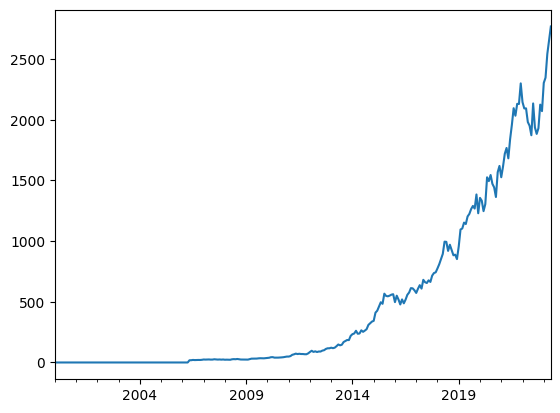

In [39]:
data["CSU_CP"].plot()

In [40]:
model = CNN_LSTM(cnn_input_size=cnn_input_size, 
                 lstm_input_size=lstm_input_size,
                 hidden_size=hidden_size, 
                 num_layers=num_layers, 
                 output_size=output_size,
                 lookback=lookback, 
                 dropout=dropout,)

In [41]:
# Get first iter of train loader using next
x_in, y_in = next(iter(train_loader))

In [42]:
x_in.shape, y_in.shape

(torch.Size([64, 100, 12, 154]), torch.Size([64, 100]))

In [43]:
model(x_in).shape

torch.Size([64, 100])

In [44]:
from torchinfo import summary

summary(model, input_size=(BATCH_SIZE, X_train_tensor.shape[1], X_train_tensor.shape[2], X_train_tensor.shape[3]), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
CNN_LSTM                                 [64, 100, 12, 154]        [64, 100]                 --                        True
├─Sequential: 1-1                        [64, 100, 12, 154]        [64, 7392]                --                        True
│    └─Conv2d: 2-1                       [64, 100, 12, 154]        [64, 64, 12, 154]         57,664                    True
│    └─ReLU: 2-2                         [64, 64, 12, 154]         [64, 64, 12, 154]         --                        --
│    └─Conv2d: 2-3                       [64, 64, 12, 154]         [64, 32, 12, 154]         18,464                    True
│    └─ReLU: 2-4                         [64, 32, 12, 154]         [64, 32, 12, 154]         --                        --
│    └─Conv2d: 2-5                       [64, 32, 12, 154]         [64, 16, 12, 154]         4,624                     True
│    └─

In [ ]:
early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")
checkpoint_callback = pl.callbacks.ModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS, log_every_n_steps=1, callbacks=[early_stopping, checkpoint_callback], enable_checkpointing=True, enable_progress_bar=True)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [38]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 48236), started 0:00:01 ago. (Use '!kill 48236' to kill it.)

In [ ]:
print(f"Best model path: {checkpoint_callback.best_model_path}")
print(f"Best model score: {checkpoint_callback.best_model_score}")

In [39]:
# /Users/johnbergmann/Developer/Master-Thesis/lightning_logs/version_55/checkpoints/epoch=6899-step=34500.ckpt 
# /Users/johnbergmann/Developer/Master-Thesis/lightning_logs/version_60/checkpoints/epoch=4679-step=42120.ckpt
# /Users/johnbergmann/Developer/Master-Thesis/lightning_logs/version_75/checkpoints/epoch=219-step=1100.ckpt
best_model = CNN_LSTM.load_from_checkpoint(checkpoint_path="/Users/johnbergmann/Developer/Master-Thesis/lightning_logs/version_75/checkpoints/epoch=219-step=1100.ckpt")

In [40]:
best_model.eval()
with torch.inference_mode():
    y_pred = best_model(X_val_tensor.to(device)).cpu().detach().numpy()

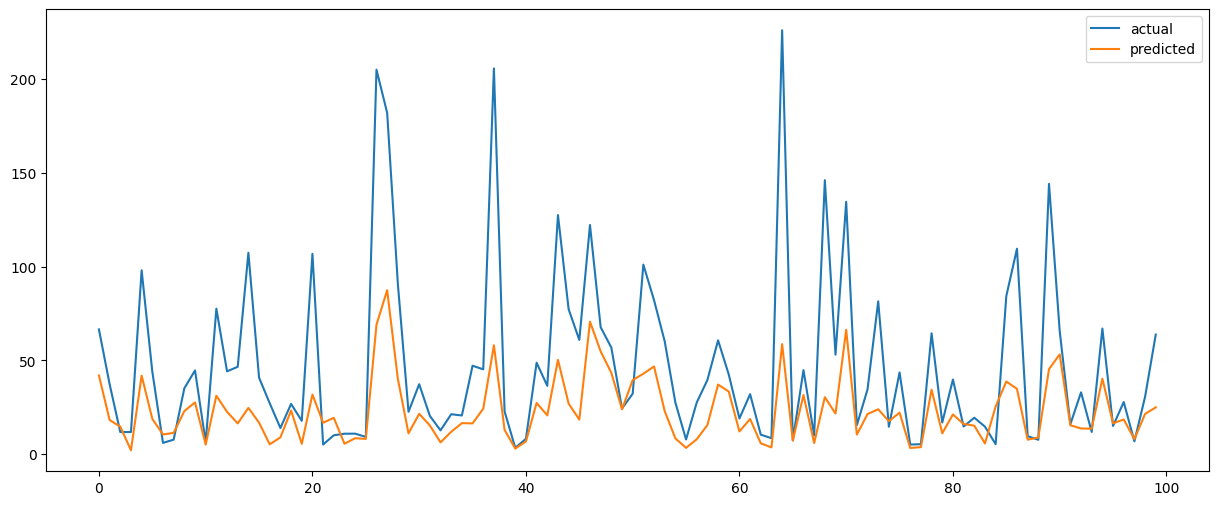

In [41]:
# Plot predictions vs actuals

plt.figure(figsize=(15, 6))
plt.plot(y_val_tensor.squeeze(), label='actual')
plt.plot(y_pred.squeeze(), label='predicted')
plt.legend()
plt.show();

In [42]:
# R2 score and MAPE
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
print(f"R2 score: {r2_score(y_val_tensor.squeeze(), y_pred.squeeze()):.4f}")
print(f"MAPE: {mean_absolute_percentage_error(y_val_tensor, y_pred):.4%}")
print(f"MAE: {mean_absolute_error(y_val_tensor, y_pred):.4f}")

R2 score: 0.2231
MAPE: 49.5030%
MAE: 25.6149


In [35]:
# Show without scientific notation
np.set_printoptions(suppress=True)
np.round(y_pred.squeeze(), 2)

array([  64.24,   41.01,   12.58,   10.36,  108.5 ,   51.98,   11.64,
          8.65,   31.55,   44.22,    6.18,   80.18,   44.23,   31.82,
         94.45,   40.61,   33.59,   17.75,   24.31,   15.1 ,   96.54,
          5.3 ,    8.45,   14.85,   13.25,    8.78,  183.9 ,  151.55,
         74.43,   16.47,   31.8 ,   25.36,   16.17,   29.82,   19.59,
         49.07,   40.99,  180.18,   21.24,    2.09,   11.87,   49.65,
         38.53,  108.39,   69.23,   59.56,  131.66,   77.32,   67.85,
         30.75,   37.36,   95.68,   89.98,   64.36,   26.58,    7.81,
         23.02,   39.19,   55.67, 2046.92,   39.25,   19.09,   33.47,
          9.28,   10.37,  199.18,    7.87,   42.98,    7.46,  135.2 ,
         41.92,  131.22,   16.63,   31.38,   65.61,   17.68,   36.03,
          4.56,    4.91,   64.6 ,   19.25,   35.32,   13.98,   21.41,
         14.39,    8.65,   86.62,  107.93,   11.99,    8.53,  156.84,
         91.13,   16.89,   29.63,   13.45,   61.93,   13.31,   26.09,
          7.36,   35

In [36]:
y_val

array([[  66.46 ,   37.29 ,   11.75 ,   11.75 ,   98.   ,   43.96 ,
           5.99 ,    7.7  ,   35.08 ,   44.6  ,    6.31 ,   77.52 ,
          44.12 ,   46.54 ,  107.36 ,   40.74 ,   27.08 ,   13.9  ,
          26.75 ,   17.72 ,  106.8  ,    5.1  ,   10.02 ,   10.86 ,
          10.9  ,    9.16 ,  204.94 ,  181.92 ,   90.91 ,   22.56 ,
          37.25 ,   20.36 ,   12.65 ,   21.26 ,   20.58 ,   47.11 ,
          45.19 ,  205.58 ,   22.74 ,    3.34 ,    8.15 ,   48.73 ,
          36.38 ,  127.43 ,   77.22 ,   60.87 ,  122.13 ,   67.63 ,
          56.8  ,   24.3  ,   32.21 ,  101.03 ,   82.07 ,   60.1  ,
          27.444,    7.79 ,   27.51 ,   39.5  ,   60.65 , 2651.82 ,
          42.42 ,   18.99 ,   31.95 ,   10.35 ,    8.47 ,  225.95 ,
           7.34 ,   44.77 ,    9.94 ,  146.02 ,   53.02 ,  134.51 ,
          15.42 ,   34.5  ,   81.44 ,   14.59 ,   43.55 ,    5.08 ,
           5.28 ,   64.4  ,   16.83 ,   39.74 ,   14.7  ,   19.4  ,
          14.64 ,    5.28 ,   84.26 ,  109.48 , 

create 2 cluster

# BAZINGA!